# Structured API Overview

This part of the book will be a deep dive into Spark’s Structured APIs. The Structured APIs are a
tool for manipulating all sorts of data, from unstructured log files to semi-structured CSV files
and highly structured Parquet files. These APIs refer to three core types of distributed collection
APIs:
* Datasets
* DataFrames
* SQL tables and views

Although they are distinct parts of the book, the majority of the Structured APIs apply to both
batch and streaming computation. This means that when you work with the Structured APIs, it
should be simple to migrate from batch to streaming (or vice versa) with little to no effort. We’ll
cover streaming in detail in Part V.

The Structured APIs are the fundamental abstraction that you will use to write the majority of
your data flows. Thus far in this book, we have taken a tutorial-based approach, meandering our
way through much of what Spark has to offer. This part offers a more in-depth exploration. In
this chapter, we’ll introduce the fundamental concepts that you should understand: the typed and
untyped APIs (and their differences); what the core terminology is; and, finally, how Spark
actually takes your Structured API data flows and executes it on the cluster. We will then
provide more specific task-based information for working with certain types of data or data
sources.

___NOTE___

Before proceeding, let’s review the fundamental concepts and definitions that we covered in Part I.
Spark is a distributed programming model in which the user specifies transformations. Multiple
transformations build up a directed acyclic graph of instructions. An action begins the process of
executing that graph of instructions, as a single job, by breaking it down into stages and tasks to
execute across the cluster. The logical structures that we manipulate with transformations and actions
are DataFrames and Datasets. To create a new DataFrame or Dataset, you call a transformation. To
start computation or convert to native language types, you call an action.

## DataFrames and Datasets
Part I discussed DataFrames. Spark has two notions of structured collections: DataFrames and
Datasets. We will touch on the (nuanced) differences shortly, but let’s define what they both
represent first.

DataFrames and Datasets are (distributed) table-like collections with well-defined rows and
columns. Each column must have the same number of rows as all the other columns (although
you can use null to specify the absence of a value) and each column has type information that
must be consistent for every row in the collection. To Spark, DataFrames and Datasets represent
immutable, lazily evaluated plans that specify what operations to apply to data residing at a
location to generate some output. When we perform an action on a DataFrame, we instruct Spark
to perform the actual transformations and return the result. These represent plans of how to
manipulate rows and columns to compute the user’s desired result.

___NOTE___

Tables and views are basically the same thing as DataFrames. We just execute SQL against them
instead of DataFrame code. We cover all of this in Chapter 10, which focuses specifically on Spark
SQL.

To add a bit more specificity to these definitions, we need to talk about schemas, which are the
way you define the types of data you’re storing in this distributed collection.

## Schemas
A schema defines the column names and types of a DataFrame. You can define schemas
manually or read a schema from a data source (often called schema on read). Schemas consist of
types, meaning that you need a way of specifying what lies where.

## Overview of Structured Spark Types
Spark is effectively a programming language of its own. Internally, Spark uses an engine called
Catalyst that maintains its own type information through the planning and processing of work. In
doing so, this opens up a wide variety of execution optimizations that make significant
differences. Spark types map directly to the different language APIs that Spark maintains and
there exists a lookup table for each of these in Scala, Java, Python, SQL, and R. Even if we use
Spark’s Structured APIs from Python or R, the majority of our manipulations will operate strictly
on Spark types, not Python types. For example, the following code does not perform addition in
Scala or Python; it actually performs addition purely in Spark:
~~~
// in Scala
val df = spark.range(500).toDF("number")
df.select(df.col("number") + 10)
# in Python
df = spark.range(500).toDF("number")
df.select(df["number"] + 10)
~~~
This addition operation happens because Spark will convert an expression written in an input
language to Spark’s internal Catalyst representation of that same type information. It then will
operate on that internal representation. We touch on why this is the case momentarily, but before
we can, we need to discuss Datasets.
#### DataFrames Versus Datasets
In essence, within the Structured APIs, there are two more APIs, the “untyped” DataFrames and
the “typed” Datasets. To say that DataFrames are untyped is aslightly inaccurate; they have
types, but Spark maintains them completely and only checks whether those types line up to those
specified in the schema at runtime. Datasets, on the other hand, check whether types conform to
the specification at compile time. Datasets are only available to Java Virtual Machine (JVM)–
based languages (Scala and Java) and we specify types with case classes or Java beans.
For the most part, you’re likely to work with DataFrames. To Spark (in Scala), DataFrames are
simply Datasets of Type Row. The “Row” type is Spark’s internal representation of its optimized
in-memory format for computation. This format makes for highly specialized and efficient
computation because rather than using JVM types, which can cause high garbage-collection and
object instantiation costs, Spark can operate on its own internal format without incurring any of
those costs. To Spark (in Python or R), there is no such thing as a Dataset: everything is a
DataFrame and therefore we always operate on that optimized format.

___NOTE___

The internal Catalyst format is well covered in numerous Spark presentations. Given that this book is
intended for a more general audience, we’ll refrain from going into the implementation. If you’re
curious, there are some excellent talks by Josh Rosen and Herman van Hovell, both of Databricks,
about their work in the development of Spark’s Catalyst engine.

Understanding DataFrames, Spark Types, and Schemas takes some time to digest. What you
need to know is that when you’re using DataFrames, you’re taking advantage of Spark’s
optimized internal format. This format applies the same efficiency gains to all of Spark’s
language APIs. If you need strict compile-time checking, read Chapter 11 to learn more about it.
Let’s move onto some friendlier and more approachable concepts: columns and rows.
#### Columns
Columns represent a simple type like an integer or string, a complex type like an array or map, or
a null value. Spark tracks all of this type information for you and offers a variety of ways, with
which you can transform columns. Columns are discussed extensively in Chapter 5, but for the
most part you can think about Spark Column types as columns in a table.
#### Rows
A row is nothing more than a record of data. Each record in a DataFrame must be of type Row, as
we can see when we collect the following DataFrames. We can create these rows manually from
SQL, from Resilient Distributed Datasets (RDDs), from data sources, or manually from scratch.
Here, we create one by using a range:
~~~
// in Scala
spark.range(2).toDF().collect()
# in Python
spark.range(2).collect()
~~~
These both result in an array of Row objects.
#### Spark Types
We mentioned earlier that Spark has a large number of internal type representations. We include
a handy reference table on the next several pages so that you can most easily reference what
type, in your specific language, lines up with the type in Spark.

Before getting to those tables, let’s talk about how we instantiate, or declare, a column to be of a
certain type.

To work with the correct Scala types, use the following:
~~~
import org.apache.spark.sql.types._
val b = ByteType
~~~
To work with the correct Java types, you should use the factory methods in the following
package:
~~~
import org.apache.spark.sql.types.DataTypes;
ByteType x = DataTypes.ByteType;
~~~
Python types at times have certain requirements, which you can see listed in Table 4-1, as do
Scala and Java, which you can see listed in Tables 4-2 and 4-3, respectively. To work with the
correct Python types, use the following:
~~~
from pyspark.sql.types import *
b = ByteType()
~~~
The following tables provide the detailed type information for each of Spark’s language
bindings.

Table 4-1. Python type reference
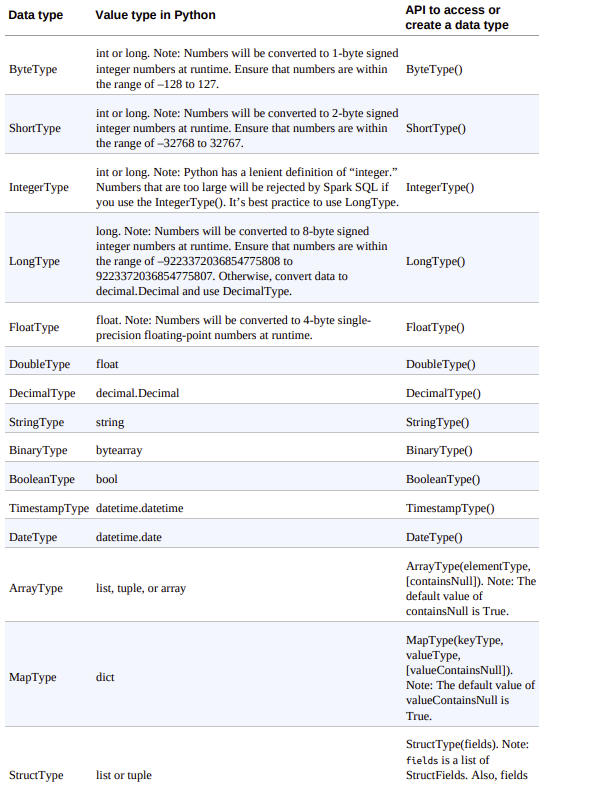
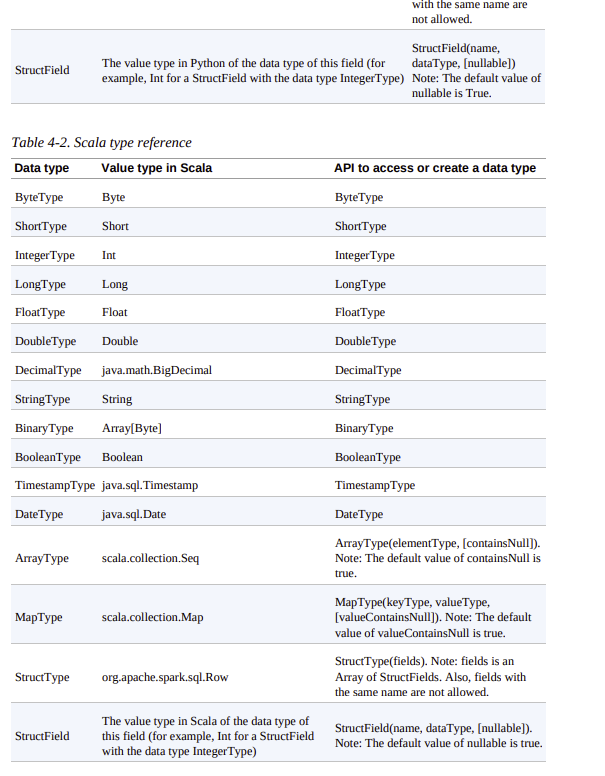
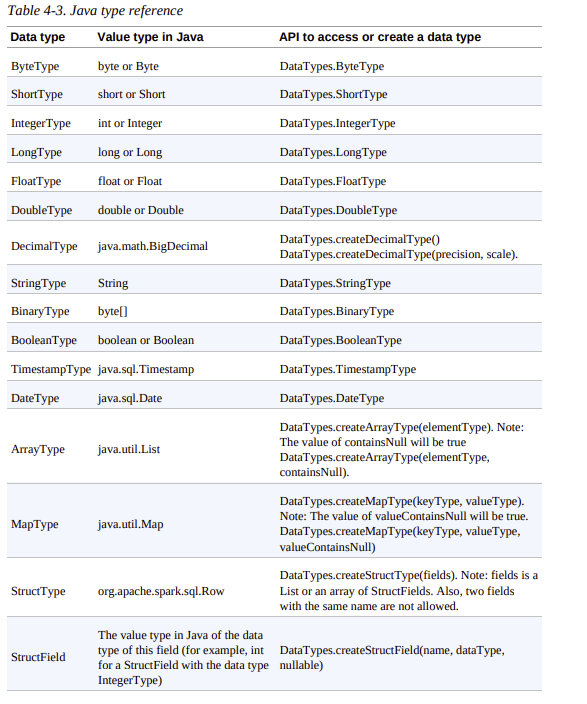
It’s worth keeping in mind that the types might change over time as Spark SQL continues to
grow so you may want to reference Spark’s documentation for future updates. Of course, all of
these types are great, but you almost never work with purely static DataFrames. You will always
manipulate and transform them. Therefore it’s important that we give you an overview of the
execution process in the Structured APIs.

## Overview of Structured API Execution
This section will demonstrate how this code is actually executed across a cluster. This will help
you understand (and potentially debug) the process of writing and executing code on clusters, so
let’s walk through the execution of a single structured API query from user code to executed
code. Here’s an overview of the steps:
1. Write DataFrame/Dataset/SQL Code.
2. If valid code, Spark converts this to a Logical Plan.
3. Spark transforms this Logical Plan to a Physical Plan, checking for optimizations along
the way.
4. Spark then executes this Physical Plan (RDD manipulations) on the cluster.

To execute code, we must write code. This code is then submitted to Spark either through the
console or via a submitted job. This code then passes through the Catalyst Optimizer, which
decides how the code should be executed and lays out a plan for doing so before, finally, the
code is run and the result is returned to the user. Figure 4-1 shows the process.
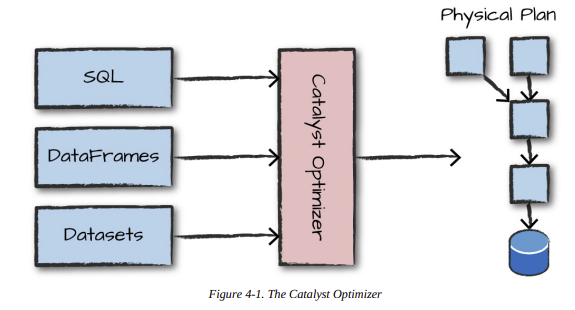
#### Logical Planning
The first phase of execution is meant to take user code and convert it into a logical plan.
Figure 4-2 illustrates this process.
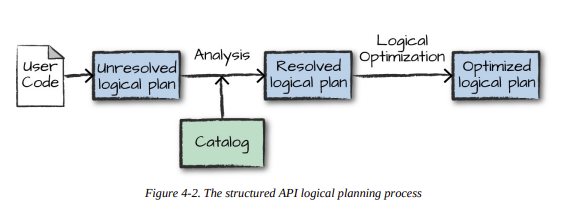
This logical plan only represents a set of abstract transformations that do not refer to executors or
drivers, it’s purely to convert the user’s set of expressions into the most optimized version. It
does this by converting user code into an unresolved logical plan. This plan is unresolved
because although your code might be valid, the tables or columns that it refers to might or might
not exist. Spark uses the catalog, a repository of all table and DataFrame information, to resolve
columns and tables in the analyzer. The analyzer might reject the unresolved logical plan if the
required table or column name does not exist in the catalog. If the analyzer can resolve it, the
result is passed through the Catalyst Optimizer, a collection of rules that attempt to optimize the
logical plan by pushing down predicates or selections. Packages can extend the Catalyst to
include their own rules for domain-specific optimizations.
#### Physical Planning
After successfully creating an optimized logical plan, Spark then begins the physical planning
process. The physical plan, often called a Spark plan, specifies how the logical plan will execute
on the cluster by generating different physical execution strategies and comparing them through
a cost model, as depicted in Figure 4-3. An example of the cost comparison might be choosing
how to perform a given join by looking at the physical attributes of a given table (how big the
table is or how big its partitions are).
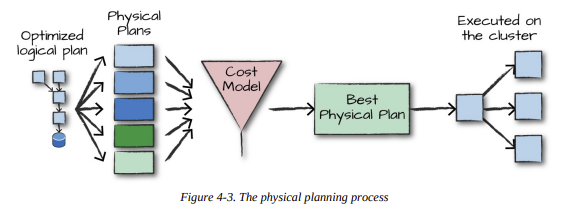
Physical planning results in a series of RDDs and transformations. This result is why you might
have heard Spark referred to as a compiler—it takes queries in DataFrames, Datasets, and SQL
and compiles them into RDD transformations for you.
#### Execution
Upon selecting a physical plan, Spark runs all of this code over RDDs, the lower-level
programming interface of Spark (which we cover in Part III). Spark performs further
optimizations at runtime, generating native Java bytecode that can remove entire tasks or stages
during execution. Finally the result is returned to the user.

## Conclusion
In this chapter, we covered Spark Structured APIs and how Spark transforms your code into
what will physically execute on the cluster. In the chapters that follow, we cover core concepts
and how to use the key functionality of the Structured APIs.